<a href="https://colab.research.google.com/github/leileihao/slc/blob/main/model_stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import re
import numpy as np
import scipy.io as so
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from datetime import datetime
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.autograd import Variable
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('/content/drive/MyDrive/WeberLab/')
import sleepy
import random

### Sleepy Function

In [ ]:
# Modified specifically to look at the 3_remix sleep state file
def load_stateidx(ppath, name, ann_name=''):
    """ load the sleep state file of recording (folder) $ppath/$name
    @Return:
        M,K         sequence of sleep states, sequence of
                    0'1 and 1's indicating non- and annotated states
    """
    ddir = os.path.join(ppath, name)
    ppath, name = os.path.split(ddir)

    if ann_name == '':
        ann_name = name

    remidxfile3 = os.path.join(ppath, name, '3_remidx_' + ann_name + '.txt')
    remidxfile_regular = os.path.join(ppath, name, 'remidx_' + ann_name + '.txt')

    # Check if '3_remidx_' file exists, if not use 'remidx_' file
    if os.path.exists(remidxfile3):
      remidxfile = remidxfile3
    else:
      remidxfile = remidxfile_regular


    f = open(remidxfile, 'r')
    lines = f.readlines()
    f.close()

    n = 0
    for l in lines:
        if re.match('\d', l):
            n += 1

    M = np.zeros(n, dtype='int')
    K = np.zeros(n, dtype='int')

    i = 0
    for l in lines :

        if re.search('^\s+$', l) :
            continue
        if re.search('\s*#', l) :
            continue

        if re.match('\d+\s+-?\d+', l) :
            a = re.split('\s+', l)
            M[i] = int(a[0])
            K[i] = int(a[1])
            i += 1

    return M,K


In [4]:
class CustomDataset(Dataset):
  def __init__(self, data, labels, window_size):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.uint8)
    self.window_size = window_size

  def __len__(self):
    return len(self.data) // self.window_size

  def __getitem__(self, index):
    x = self.data[index*window_size:index*window_size+window_size][:]
    print()
    if (index*window_size >= (len(self.data) - window_size)):
      y = self.labels[index*window_size-1]
    else:
      y = self.labels[index*window_size] # so it doesn't have an out of bound

    y = y.long()

    # Perform one-hot encoding on y
    y = y - 1 # shift the labels to start at 0
    y_encoded = F.one_hot(y, num_classes = 3)

    x = x.view(-1, 2)

    return x, y_encoded

# Stage 1 Preparations for Stage 2

## Stage 1 Model Architecture

In [9]:
# Check that GPU is being used for model
torch.manual_seed(46) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.9.0+cu126
cuda:0


In [6]:
from torch import sparse
# Bidirectional LSTM
class biLSTM(nn.Module):
  def __init__(self, input_size, window_len, hidden_size=128, num_layers=2, dropout=0.2):
    super(biLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
    self.fc = nn.Sequential(
          nn.BatchNorm1d(hidden_size*2),
          nn.Linear(hidden_size*2, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, 64),
          nn.ReLU(),
          nn.Linear(64, 3), # three brain states: 1, 2, 3 (--> now 0, 1, 2 due to shift)
    )

    self.softmax = nn.Softmax(dim=1)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    batch_size, seq_len, num_channels = x.size()

    h0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)
    c0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)

    x = x.permute(0, 1, 2)  # Transpose the tensor to match the shape (batch, seq_len, num_channels)

    outl, _ = self.lstm(x, (h0, c0))
    out = outl[:, -1, :]

    out = self.fc(out)
    return out

## Process the unshuffled EEG through the Stage 1 model

In [7]:
random.seed(46)

In [ ]:
import io
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

biLSTM_model = CPU_Unpickler(open('drive/My Drive/MultiVanillaModelPart1N.pkl',"rb")).load()

In [ ]:
# Create segments for training
def create_segments(array, segment_length, overlap):
    segments = []
    stride = segment_length - overlap
    for i in range(0, len(array) - segment_length + 1, stride):
        segments.append(array[i:i+segment_length])
    return segments

segment_length = 51
overlap = 50


In [ ]:
ppath = '/content/drive/MyDrive/SleepClass/Custom_Dataset_7'

recordings = os.listdir(ppath)
ndown = 4
factor = 2500 #(time bin * sampling rate)
recordings

['c18_020418n1',
 'c19_020418n1',
 'c20_020618n1',
 'c21_020618n1',
 'c30_030418n1',
 'J10_052318n1',
 'J45_100918n1',
 'J12_052818n1',
 'J35_082118n1',
 'J46_100918n1',
 'J9_052318n1',
 'c36_032518n1',
 'J17_062618n1',
 'AC81_081221n1',
 'AC85_082321n1']

In [ ]:
from sklearn.preprocessing import StandardScaler

validation_split = 0.2

training_data = []
label_data = []

EEG = np.array([])
EMG = np.array([])
M = np.array([])

train_shape_repo = []
test_shape_repo = []

for name in recordings:
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1] # cut off the end that doesn't match
  len_m = len(m)

  eeg = so.loadmat(os.path.join(ppath, name, 'EEG.mat'), squeeze_me=True)['EEG']
  eeg = eeg[:(len_m) * factor]    # truncate eeg length to the number of windows
  eeg = sleepy.downsample_vec(eeg, ndown)
  eeg = eeg.astype('float16')

  emg = so.loadmat(os.path.join(ppath, name, 'EMG.mat'), squeeze_me=True)['EMG']
  emg = emg[:(len_m) * factor]
  emg = sleepy.downsample_vec(emg, ndown)
  emg = emg.astype('float16')

  # Change all the sleep states above 3 to NREM -- can change to separate out microarousals
  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
    if m[i] == 0: # changed the unannotated segments to NREM
      m[i] = 3

  X = eeg
  Y = m
  Z = emg

  # Do the test-validation set split
  x_indices = list(range(len(X)))
  y_indices = list(range(len(Y)))
  # x_split = int(np.floor(validation_split * len(X)))
  y_split = int(np.floor(validation_split * len(Y)))
  x_split = y_split * int(factor/ndown+0.1)

  x_train_indices, x_val_indices = x_indices[x_split:], x_indices[:x_split]
  y_train_indices, y_val_indices = y_indices[y_split:], y_indices[:y_split]

  x_train = X[x_train_indices].astype('<f8')
  x_test = X[x_val_indices].astype('<f8')
  z_train = Z[x_train_indices].astype('<f8')
  z_test = Z[x_val_indices].astype('<f8')

  ## Doing normalization for each recording independently
  mean_x = np.nanmean(x_train)
  std_x = np.nanstd(x_train)

  x_train = ((x_train - mean_x) / std_x).astype('<f8')
  x_test = ((x_test - mean_x) / std_x).astype('<f8')

  mean_z = np.nanmean(z_train)
  std_z = np.nanstd(z_train)

  z_train = ((z_train - mean_z) / std_z).astype('<f8')
  z_test = ((z_test - mean_z) / std_z).astype('<f8')


  y_train = Y[y_train_indices].astype('int8')
  y_test = Y[y_val_indices].astype('int8')


  print("Recording {}, eeg mean: {}, eeg std: {}, emg mean: {}, emg std: {}"
          .format(name, mean_x, std_x, mean_z, std_z))

  if (len(y_test) * 625 != len(x_test)) or (len(y_train) * 625!=len(x_train)):
    print('Length error for', name)
    False_flag = 1

  EEG = np.append(EEG, x_train)
  EMG = np.append(EMG, z_train)
  M = np.append(M, y_train)

  EEG = np.append(EEG, x_test)
  EMG = np.append(EMG, z_test)
  M = np.append(M, y_test)

  train_shape_repo.append(y_train.shape[0])   ## save the dataset length of each recording for later use
  test_shape_repo.append(y_test.shape[0])


Recording c18_020418n1, eeg mean: -0.09729233593410916, eeg std: 43.51196222327882, emg mean: -0.09720869127909343, emg std: 49.475690164147714
Recording c19_020418n1, eeg mean: -0.09741477436489529, eeg std: 69.04191819560756, emg mean: -0.09743111794259814, emg std: 44.777423211045765
Recording c20_020618n1, eeg mean: -0.0974829969882965, eeg std: 58.803999630872745, emg mean: -0.09722581181526184, emg std: 52.670480132962005
Recording c21_020618n1, eeg mean: -0.09715014465649922, eeg std: 73.09368704387148, emg mean: -0.09726402431594001, emg std: 47.56894731291857
Recording c30_030418n1, eeg mean: -0.09653628292386494, eeg std: 88.5230110794834, emg mean: -0.09688220111301966, emg std: 46.44975305751588
Recording J10_052318n1, eeg mean: -0.09689520683288574, eeg std: 93.24638709724168, emg mean: -0.0969138018714057, emg std: 91.32073252604764
Recording J45_100918n1, eeg mean: -0.09748319424897238, eeg std: 107.63649720376205, emg mean: -0.09742848924624374, emg std: 60.966279937375

In [ ]:
M_upsampled = np.repeat(M, 625)

input = np.vstack((EEG, EMG)).T

window_size = 625
input_size = 2
dataset = CustomDataset(input, M_upsampled, window_size=window_size)

# Create data loaders
batch_size = 128
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
biLSTM_model

biLSTM(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
biLSTM_model.eval()
predicted_labels = []
real_labels = []
val_correct = 0
val_total = 0
with torch.no_grad():
  for iter, (input, target) in enumerate(loader):
      input = input.to(device).double()
      target = target.to(device).double()

      output = biLSTM_model(input)

      predicted_labels.extend(output.tolist())
      real_labels.extend(target.tolist())

predicted_labels = torch.tensor(predicted_labels)
real_labels = torch.tensor(real_labels)

val_output = F.one_hot(torch.max(predicted_labels, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
if val_output.dim() == 1:
  predicted_classes = torch.argmax(val_output, dim=0)
else:
  predicted_classes = torch.argmax(val_output, dim=1)

all_total = real_labels.size(0)   # the total number of dataset items

In [ ]:
for i, name in enumerate(recordings):

  train_num = train_shape_repo[i]   # retrieve the number of train and test items in this recording
  test_num = test_shape_repo[i]
  train_total = int(np.sum(train_shape_repo)+0.1)

  train_pre = int(np.sum(train_shape_repo[:i])+0.1)    # the previously already calculated index number in other recordings
  test_pre = train_total + int(np.sum(test_shape_repo[:i])+0.1)

  test_end_index = test_pre + test_num   # the test end index of selecting the current recording items
  if test_end_index >= all_total:
    test_end_index = None


  test_correct = ((predicted_classes[train_pre:train_pre+train_num] == torch.argmax(real_labels, dim=1)[train_pre:train_pre+train_num]).sum().item()
                 + (predicted_classes[test_pre:test_end_index] == torch.argmax(real_labels, dim=1)[test_pre:test_end_index]).sum().item())

  test_session_total = train_num + test_num

  test_session_acc = 100 * test_correct / test_session_total

  print("Test Subject: {} | biLSTM Accuracy: {}"
          .format(name, test_session_acc))


  ## Here to concate segments of 2nd stage data
  segments = create_segments(torch.cat((predicted_labels[test_pre:test_end_index], predicted_labels[train_pre:train_pre+train_num]), dim=0),
                            segment_length, overlap)

  training_data.extend(segments)
  print(len(segments))

  # if test_end_index == None:    # change it to comply with test_end_index-idx
  #   test_end_index = 0

  idx = int(overlap/2)
  labels = torch.cat((real_labels[idx+test_pre:test_end_index], real_labels[train_pre : train_pre+train_num - idx]), dim=0)

  label_data.extend(labels)
  print(len(labels))

Test Subject: c18_020418n1 | biLSTM Accuracy: 89.49652777777777
11470
11470
Test Subject: c19_020418n1 | biLSTM Accuracy: 90.21701388888889
11470
11470
Test Subject: c20_020618n1 | biLSTM Accuracy: 91.31076388888889
11470
11470
Test Subject: c21_020618n1 | biLSTM Accuracy: 89.28819444444444
11470
11470
Test Subject: c30_030418n1 | biLSTM Accuracy: 89.24603174603175
10030
10030
Test Subject: J10_052318n1 | biLSTM Accuracy: 92.09722222222223
7150
7150
Test Subject: J45_100918n1 | biLSTM Accuracy: 88.33333333333333
12190
12190
Test Subject: J12_052818n1 | biLSTM Accuracy: 89.13194444444444
8590
8590
Test Subject: J35_082118n1 | biLSTM Accuracy: 91.30208333333333
11470
11470
Test Subject: J46_100918n1 | biLSTM Accuracy: 88.48856209150327
12190
12190
Test Subject: J9_052318n1 | biLSTM Accuracy: 88.68055555555556
7150
7150
Test Subject: c36_032518n1 | biLSTM Accuracy: 60.6712962962963
12910
12910
Test Subject: J17_062618n1 | biLSTM Accuracy: 89.95144789318536
11484
11484
Test Subject: AC81_0

# Stage 2: Fully Connected Layer

In [ ]:
# Test-Train Split
X = np.array(training_data)
Y = np.array(label_data)

x_train = []
x_test = []
y_train = []
y_test = []
pointer = 0

for i, _ in enumerate(train_shape_repo):
  ## Doing normalization for each recording independently
  pointer_temp = pointer + test_shape_repo[i] - idx
  x_temp_train = X[pointer_temp:pointer_temp+train_shape_repo[i] - idx]
  axis = (0, 2)   ## this is to ensure the same timepoint is divided by the same mean, while this mean is representing the whole trainig set
  mean_x = np.nanmean(x_temp_train, axis=axis, keepdims=True)
  std_x = np.nanstd(x_temp_train, axis=axis, keepdims=True)

  x_temp_train = ((x_temp_train - mean_x) / std_x).astype('<f8')
  x_temp_test = ((X[pointer:pointer+test_shape_repo[i] - idx] - mean_x) / std_x).astype('<f8')

  x_test.extend(x_temp_test)
  y_test.extend(Y[pointer:pointer+test_shape_repo[i] - idx])
  pointer += test_shape_repo[i] - idx
  x_train.extend(x_temp_train)
  y_train.extend(Y[pointer:pointer+train_shape_repo[i] - idx])
  pointer += train_shape_repo[i] - idx

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
x_example = x_test[:, 25]
y_example = y_test
correct = np.argmax(x_example, axis=1) == np.argmax(y_example, axis=1)
total = len(x_example)
correct.sum() / total

np.float64(0.9057191871843816)

In [ ]:
### Balancing AND normalization
from scipy.special import softmax
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=27)
x_restrain, M_restrain = rus.fit_resample(x_train.reshape(len(np.argmax(y_train, axis=1)), -1), np.argmax(y_train, axis=1))
x_restrain = x_restrain.reshape(-1, segment_length, 3)      # 3 for 3 sleep states
y_restrain = np.eye(3)[M_restrain]

def minmax_scale(x, axis=None):
    min = np.min(x, axis=axis, keepdims=True)
    max = np.max(x, axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

def zscore_scale(x, axis=None):
    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std = np.where(std == 0, 1, std)
    result = (x-mean)/std
    return result

# x_restrain = StandardScaler().fit_transform(x_restrain.reshape(len(x_restrain),-1)).reshape(-1, segment_length, 3)
# x_test = StandardScaler().fit_transform(x_test.reshape(len(x_test),-1)).reshape(-1, segment_length, 3)

# x_test = zscore_scale(x_test, axis=2)
# x_restrain = zscore_scale(x_restrain, axis=2)

In [ ]:
x_test.shape

(41387, 51, 3)

In [ ]:
x_example = x_test[:, 25]
y_example = y_test
correct = np.argmax(x_example, axis=1) == np.argmax(y_example, axis=1)
total = len(x_example)
correct.sum() / total

np.float64(0.9057191871843816)

In [ ]:
x_example = x_restrain[:, 25]
y_example = y_restrain
correct = np.argmax(x_example, axis=1) == np.argmax(y_example, axis=1)
total = len(x_example)
correct.sum() / total

np.float64(0.8723031740652886)

In [ ]:
np.unique(y_train, axis=0, return_counts=True)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32),
 array([97712, 57161, 11804]))

In [ ]:
np.unique(y_test, axis=0, return_counts=True)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32),
 array([21323, 17345,  2719]))

In [ ]:
y_test[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
class CustomDatasetFC(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y

In [ ]:
# Create custom datasets with normalized data

train_dataset = CustomDatasetFC(x_restrain, y_restrain)
test_dataset = CustomDatasetFC(x_test, y_test)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Stage 2 Model Architecture

In [8]:
# Check that GPU is being used for model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.9.0+cu126
cuda:0


In [ ]:
class FCNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(FCNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(segment_length * 3, 64), # ADD TO SEG LEGTH IF WE ARE LOOKING AT SPEC
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        # out = self.fc(x)
        out = self.fc(x) + x[:,int((segment_length-1)/2+0.1)]   ## (segment_length-1)/2
        return out

In [ ]:
FCNet()

FCNet(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=153, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=32, out_features=3, bias=True)
  )
)

## Stage 2 Model Training

In [ ]:
## Train the Stage 2 model

start_time = datetime.now()

num_epochs = 100
learning_rate = 1e-5

fc_model = FCNet(dropout=0.2).to(device).double()

loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=learning_rate, weight_decay=1e-2)


fc_loss_LIST = []
fc_acc_LIST = []

fc_val_loss_LIST = []
fc_val_acc_LIST = []

fc_predict = []
fc_real = []

predict_len = 3


for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    f1_scores = []
    auc_scores = []

    train_cat = np.array([0,0,0])
    test_cat = np.array([0,0,0])

    ### Training Model
    fc_model.train()
    for iter, (input, target) in enumerate(train_loader):
      if input.shape[0] > 1:
        input = input.to(device).double()
        target = target.to(device).double()

        output = fc_model(input)
        loss = loss_criterion(output, target)

        optimizer.zero_grad() # Reset the optimizer tensor gradient every mini-batch
        loss.backward() # Do back propagation
        optimizer.step() # Update the weight using the gradients from back propagation by learning step

        train_loss += loss.item() # Get loss and add to accumulated loss for each epoch
        train_total += target.size(0)
        output = F.one_hot(torch.max(output, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
        train_correct += (torch.argmax(output, dim=1) == torch.argmax(target, dim=1)).sum().item()

        train_cat += output.cpu().numpy().sum(axis=0)
        if iter%50 == 0:
          print('Runing training output distribution in this epoch: ', np.round(train_cat/train_cat.sum(), 3))



    ### Evaluating Model
    fc_model.eval()
    with torch.no_grad():
        for iter, (input, target) in enumerate(test_loader):
            input = input.to(device).double()
            target = target.to(device).double()

            val_output = fc_model(input)

            val_loss += loss_criterion(val_output, target).item()
            val_total += target.size(0)
            val_output = F.one_hot(torch.max(val_output, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
            val_correct += (torch.argmax(val_output, dim=1) == torch.argmax(target, dim=1)).sum().item()

            test_cat += val_output.cpu().numpy().sum(axis=0)
            if iter%50 == 0:
              print('Runing testing output distribution in this epoch: ', np.round(test_cat/test_cat.sum(), 3))

            # Calculate the F1 and AUC scores
            f1 = f1_score(target.cpu(), val_output.cpu(), average='macro', zero_division=0)
            f1_scores.append(f1)

            auc = roc_auc_score(target.cpu().flatten(), val_output.cpu().flatten(), multi_class='ovr', average='weighted')
            auc_scores.append(auc)

            if epoch + 1 == num_epochs:
              val_output_classes = torch.argmax(val_output, dim=1) + 1
              fc_predict.extend(val_output_classes.tolist())
              target_classes = torch.argmax(target, dim=1) + 1
              fc_real.extend(target_classes.tolist())

    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    avg_f1_score = sum(f1_scores) / len(f1_scores)
    avg_auc_score = sum(auc_scores) / len(auc_scores)

    fc_loss_LIST.append(train_loss)
    fc_acc_LIST.append(train_accuracy)

    fc_val_loss_LIST.append(val_loss)
    fc_val_acc_LIST.append(val_accuracy)

    print("Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%, F1 Score: {:.4f}, AUC Score: {:.4f}"
          .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, avg_f1_score, avg_auc_score))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Runing training output distribution in this epoch:  [0.297 0.336 0.367]
Runing training output distribution in this epoch:  [0.279 0.345 0.376]
Runing training output distribution in this epoch:  [0.293 0.332 0.376]
Runing training output distribution in this epoch:  [0.3   0.324 0.376]
Runing training output distribution in this epoch:  [0.303 0.322 0.375]
Runing training output distribution in this epoch:  [0.306 0.318 0.376]
Runing testing output distribution in this epoch:  [0.086 0.414 0.5  ]
Runing testing output distribution in this epoch:  [0.093 0.382 0.525]
Runing testing output distribution in this epoch:  [0.089 0.383 0.528]
Runing testing output distribution in this epoch:  [0.089 0.382 0.529]
Runing testing output distribution in this epoch:  [0.088 0.382 0.531]
Runing testing output distribution in this epoch:  [0.087 0.382 0.531]
Runing testing output distribution in this epoch:  [0.086 0.382 0.532]
Epoch [1/100], Train Loss: 0.4916, Train Accuracy: 83.80%, Val Loss: 0.

In [ ]:
import pickle

## Save classification model as a pickle file
# import gc
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

#2Ov2 -- Custom Dataset 7 with both stages 1 and 2 normalized individually

# pick_insert = open('drive/My Drive/MultiVanillaModelPart2Ov2.pkl','wb')
# pickle.dump(fc_model, pick_insert)
# pick_insert.close()

Mounted at /content/drive


In [ ]:
np.array(fc_val_acc_LIST)


array([91.11315147, 91.71478967, 91.92983304, 92.07963853, 92.28501703,
       92.39857926, 92.48073066, 92.56288206, 92.65953077, 92.66677942,
       92.91564984, 92.98813637, 93.08961751, 93.09203373, 93.20317974,
       93.30224467, 93.32640684, 93.43513664, 93.54145021, 93.55836374,
       93.67917462, 93.80965037, 93.87247203, 93.87488825, 93.96912074,
       94.01261266, 94.06818566, 94.17208302, 94.17449924, 94.25665064,
       94.25423442, 94.33638582, 94.36538043, 94.31705608, 94.3750453 ,
       94.40887235, 94.43786696, 94.38471017, 94.48860753, 94.5248508 ,
       94.52726702, 94.5248508 , 94.52243458, 94.46686157, 94.54659676,
       94.58525624, 94.55384541, 94.63358059, 94.55142919, 94.64324546,
       94.64324546, 94.66982386, 94.64082925, 94.63841303, 94.68673738,
       94.71814821, 94.69398603, 94.69156982, 94.6625752 , 94.75197526,
       94.75922391, 94.76647256, 94.7447266 , 94.80271583, 94.75680769,
       94.80996448, 94.73989417, 94.79305096, 94.74714282, 94.79

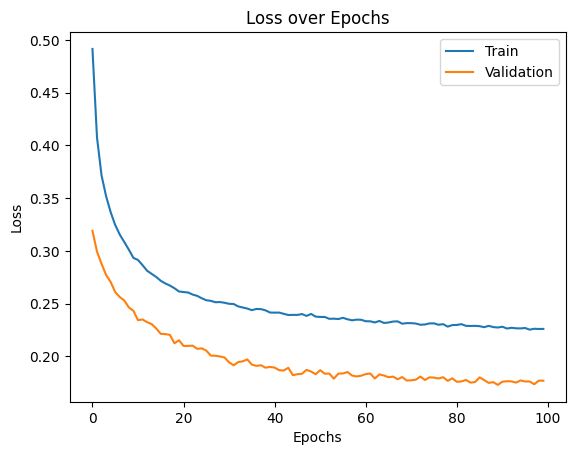

In [ ]:
fig4, ax4 = plt.subplots()
ax4.plot(fc_loss_LIST, label = 'Train')
ax4.plot(fc_val_loss_LIST, label = 'Validation')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

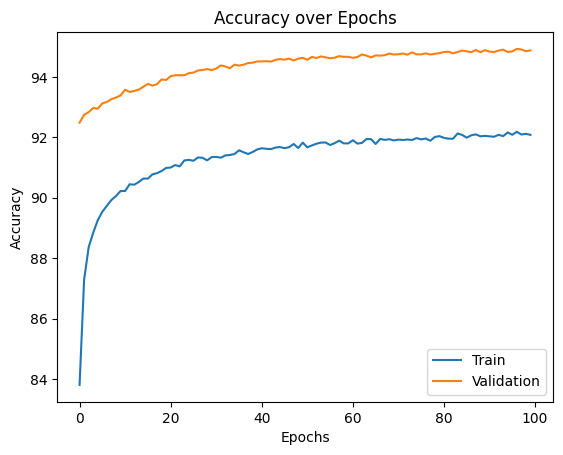

In [ ]:
fig5, ax5 = plt.subplots()
ax5.plot(fc_acc_LIST, label = 'Train')
ax5.plot(fc_val_acc_LIST, label = 'Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
## Obtain the confusion matrix

from sklearn import metrics
y_true = fc_real
y_pred = fc_predict
fc_cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

xticks = ['REM', 'Wake', 'NREM']
yticks = ['REM', 'Wake', 'NREM']

fig6, ax6 = plt.subplots(figsize=(5, 5))
fig = sns.heatmap(fc_cf_matrix/np.sum(fc_cf_matrix), annot=True,
            fmt='.2%', cmap='Blues', cbar=False, xticklabels=xticks, yticklabels=yticks)

fig6.suptitle('Confusion Matrix', fontsize=22)
ax6.set_xlabel('Predicted', fontsize=18)
ax6.set_ylabel('Actual', fontsize=18)